In [1]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from sklearn.cross_validation import train_test_split
import numpy as np

Using TensorFlow backend.
/afs/cern.ch/work/m/mkagan/public/miniconda3/envs/testenv/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as pl
import matplotlib.colors as colors
import matplotlib.cm as cmap
from sklearn.metrics import roc_curve, roc_auc_score

# Preprocess samples

In [3]:
files=['mc16_13TeV:mc16_13TeV.361023.Pythia8EvtGen_A14NNPDF23LO_jetjet_JZ3W.deriv.DAOD_JETM6.e3668_s3126_r9364_r9315_p3600.h5','mc16_13TeV:mc16_13TeV.361024.Pythia8EvtGen_A14NNPDF23LO_jetjet_JZ4W.deriv.DAOD_JETM6.e3668_s3126_r9364_r9315_p3600.h5','mc16_13TeV:mc16_13TeV.361026.Pythia8EvtGen_A14NNPDF23LO_jetjet_JZ6W.deriv.DAOD_JETM6.e3569_s3126_r9364_r9315_p3600.h5','mc16_13TeV:mc16_13TeV.361027.Pythia8EvtGen_A14NNPDF23LO_jetjet_JZ7W.deriv.DAOD_JETM6.e3668_s3126_r9364_r9315_p3600.h5','mc16_13TeV:mc16_13TeV.361028.Pythia8EvtGen_A14NNPDF23LO_jetjet_JZ8W.deriv.DAOD_JETM6.e3569_s3126_r9364_r9315_p3600.h5','mc16_13TeV:mc16_13TeV.361029.Pythia8EvtGen_A14NNPDF23LO_jetjet_JZ9W.deriv.DAOD_JETM6.e3569_s3126_r9364_r9315_p3600.h5']
f_bkg = h5py.File('mcdata/'+files[0])
f_sig = h5py.File('mcdata/signal_Vs.h5')
f_bkg['branches'][:]
pt_min=200.
pt_max=500.

In [4]:
arr_bkg = np.array(f_bkg['lundjets_InDetTrackParticles'])
print arr_bkg.shape
arr_bkg = arr_bkg.reshape(arr_bkg.shape[0]*arr_bkg.shape[1],20,6)
arr_sig = np.array(f_sig['lundjets_InDetTrackParticles'])
arr_sig = arr_sig.reshape(arr_sig.shape[0]*arr_sig.shape[1],20,6)
print arr_bkg[300,:,:]

(1000000, 2, 20, 6)
[[  9.65082169e-01   5.14076510e-03   2.47367203e+02   6.84367142e+01
    2.10000000e+01   6.00043118e-01]
 [  6.11582160e-01   2.60056593e-02   2.47367203e+02   6.84367142e+01
    2.10000000e+01   3.01984835e+00]
 [  2.84144580e-01   2.43875887e-02   2.47367203e+02   6.84367142e+01
    2.10000000e+01   2.75831461e+00]
 [  2.53698438e-01   4.90890145e-01   2.47367203e+02   6.84367142e+01
    2.10000000e+01   5.45973129e+01]
 [  1.96089849e-01   6.79854453e-02   2.47367203e+02   6.84367142e+01
    2.10000000e+01   3.85062814e+00]
 [  1.52845576e-01   2.70790868e-02   2.47367203e+02   6.84367142e+01
    2.10000000e+01   1.42964482e+00]
 [  1.03430949e-01   4.64595407e-02   2.47367203e+02   6.84367142e+01
    2.10000000e+01   2.38644600e+00]
 [  6.09962679e-02   2.12396398e-01   2.47367203e+02   6.84367142e+01
    2.10000000e+01   1.04038916e+01]
 [  5.22892624e-02   1.37933418e-01   2.47367203e+02   6.84367142e+01
    2.10000000e+01   5.32146215e+00]
 [  4.75873314e-0

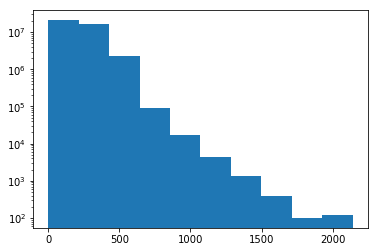

In [5]:
# Jet pt
pt_sig=arr_sig[:,:,2].flatten()
pl.hist(pt_sig)
pl.yscale('log')
pl.show()

In [6]:
nEvent=arr_sig.shape[0]
print "array size before cut:"
print "signal:"
print (len(arr_sig))
print 'background:'
print len(arr_bkg)

# Cut out problematic radiation patterns (Delta_R of first radiation branch = 0)
arr_sig = arr_sig[arr_sig[0:nEvent,0,0]!=1.]
arr_bkg = arr_bkg[arr_bkg[0:nEvent,0,0]!=1.]
print 'array size after cut:'
print 'signal:'
print arr_sig.shape
print 'background:'
print arr_bkg.shape
arr_sig[arr_sig==1.]=1e-3
arr_bkg[arr_bkg==1.]=1e-3

array size before cut:
signal:
2000000
background:
2000000
array size after cut:
signal:
(1012694, 20, 6)
background:
(1007527, 20, 6)


In [7]:
# cut on pt
cut_sig=[]
for i in range(arr_sig.shape[0]):
    if ((arr_sig[i,0,2]>pt_min) and (arr_sig[i,0,2]<pt_max)):
        cut_sig.append(True)
    else:
        cut_sig.append(False)

cut_bkg=[]
for i in range(arr_bkg.shape[0]):
    if ((arr_bkg[i,0,2]>pt_min) and (arr_bkg[i,0,2]<pt_max)):
        cut_bkg.append(True)
    else:
        cut_bkg.append(False)
arr_sig = arr_sig[cut_sig]
arr_bkg = arr_bkg[cut_bkg]

In [8]:
print arr_sig.shape
print arr_bkg.shape

(984406, 20, 6)
(1005499, 20, 6)


In [9]:
# x=log(1/Delta), y=log(Delta*pt2)
lund_x_sig=np.log(1/arr_sig[:,:,0]).flatten()
lund_y_sig=np.log(np.array(arr_sig[:,:,5]).flatten()*np.array(arr_sig[:,:,0]).flatten())
lund_x_bkg=np.log(1/arr_bkg[:,:,0]).flatten()
lund_y_bkg=np.log(np.array(arr_bkg[:,:,5]).flatten()*np.array(arr_bkg[:,:,0]).flatten())

signal=np.zeros((arr_sig.shape[0],2,20),dtype=float)
background=np.zeros((arr_bkg.shape[0],2,20),dtype=float)
for i in range(signal.shape[0]):
    for j in range(20):
        signal[i,0,j]=lund_x_sig[j+i*20]
        signal[i,1,j]=lund_y_sig[j+i*20]
    
for i in range(background.shape[0]):
    for j in range(20):
        background[i,0,j]=lund_x_bkg[j+i*20]
        background[i,1,j]=lund_y_bkg[j+i*20]
    
y_sig=np.zeros(arr_sig.shape[0])
y_bkg=np.ones(arr_bkg.shape[0])
y_sig=np_utils.to_categorical(y_sig,2)
y_bkg=np_utils.to_categorical(y_bkg,2)
#target=np.concatenate([y_sig,y_bkg])
#print target[:10]
print y_sig.shape
print y_bkg.shape

(984406, 2)
(1005499, 2)


In [ ]:
# Split training set and test set
x_train_sig,x_test_sig,y_train_sig,y_test_sig = train_test_split(signal,y_sig,test_size=0.5, random_state = 4)
x_train_bkg,x_test_bkg,y_train_bkg,y_test_bkg = train_test_split(background,y_bkg,test_size=0.05, random_state = 4)
x_train=np.concatenate([x_train_sig,x_train_bkg])
x_test=np.concatenate([x_test_sig,x_test_bkg])
y_train=np.concatenate([y_train_sig,y_train_bkg])
y_test=np.concatenate([y_test_sig,y_test_bkg])

# Build CNN model and training

In [ ]:
x_train=x_train.astype('float32')
x_test=x_test.astype('float32')
print(x_train.shape)
model=Sequential()
model.add(Conv1D(32,5,activation='relu',input_shape=(2,20), padding='same'))
#filters: number of different weights, kernal size: dimension of weight vector (matrix)
#print model.output_shape
#model.add(Conv1D(filters=32,kernal_size=5, activation='relu',paddling='same'))
model.add(MaxPooling1D(pool_size=2,padding='same'))
model.add(Dropout(0.25))
model.add(Conv1D(32,5,activation='relu',input_shape=(2,20),padding='same'))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(x_train,y_train,batch_size=100,epochs=6,verbose=1)
score=model.evaluate(x_test,y_test,verbose=0)
print score

(1447427, 2, 20)
Epoch 1/6
1447427/1447427 [==============================] - 140s - loss: 0.4741 - acc: 0.7808   
Epoch 2/6
1447427/1447427 [==============================] - 138s - loss: 0.4508 - acc: 0.7988   
Epoch 3/6
1447427/1447427 [==============================] - 144s - loss: 0.4465 - acc: 0.8014   
Epoch 4/6
1447427/1447427 [==============================] - 137s - loss: 0.4453 - acc: 0.8027   
Epoch 5/6
1447427/1447427 [==============================] - 142s - loss: 0.4439 - acc: 0.8030   
Epoch 6/6
 968700/1447427 [===================>..........] - ETA: 48s - loss: 0.4429 - acc: 0.8038

# Test model and plotting

In [ ]:
y_predict=model.predict(x_test,batch_size=32,verbose=0)
#print y_predict[1]
#print y_test.shape
#print y_predict.shape
fpr, tpr, thresholds = roc_curve(y_test[:,0], y_predict[:,0])
roc_auc = roc_auc_score(y_test, y_predict) # cacluate area under curve
roc=[roc_auc]
fpr[fpr==0.]=1e-5
np.save('fpr_W_lowpt_2var.npy',fpr)
np.save('tpr_W_lowpt_2var.npy',tpr)
np.save('roc_W_lowpt_2var.npy',roc)

In [ ]:
pl.figure()
lw = 2
fpr[fpr==0.]=1e-5
print fpr[0]
pl.plot(tpr, 1./fpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
pl.xlim([0.3, 1.0])
#pl.ylim([0.0, 1.05])
pl.yscale('log')
pl.ylim(1,1e4)
pl.xlabel('Signal efficiency ($\epsilon_{sig}$)')
pl.ylabel('Background rejection ($1/\epsilon_{bkg}$)')
#pl.title('Receiver operating characteristic example')
pl.legend(loc="lower right")
ptrange='pT = [{0}, {1}] GeV'.format(int(pt_min),int(pt_max))
pl.text(0.75,4e3,ptrange)
pl.show()